In [1]:
import random

from string import ascii_lowercase

import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

EPS = 1e-7

%matplotlib inline

## Dataset 

In [2]:
# Load file and take only the second column, which is called "city_ascii" - so simple city names
# Load file and take only the second column, which is called "city_ascii" - so simple city names
city_names = [row.split(",")[1].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  # don't take header row
city_names[:10]


# Use code below to only use cities from a specific country
# COUNTRY = "finland"
# city_names = []
# rows = [row for row in open("worldcities.csv").readlines()]
# for row in rows:
#   parts = row.split(",")
#   city = parts[1].replace('"', "")
#   country = parts[4].replace('"', "")
#   if country.lower() != COUNTRY:
#     continue
#   else:
#     print(f"{country} -> {city}")
#   city_names.append(city.lower())
#   #city_names = city_names[1:]  # don't take header row's value
# city_names[:10]

['Tokyo',
 'Jakarta',
 'Delhi',
 'Guangzhou',
 'Mumbai',
 'Manila',
 'Shanghai',
 'Sao Paulo',
 'Seoul',
 'Mexico City']

In [3]:
# We need a special characters to denote the start and end of a city name
SPACE = " "
start_end_char = "."
allowed_chars = SPACE + ascii_lowercase
all_chars = start_end_char + allowed_chars
vocab_size = len(all_chars)

print(f"{ascii_lowercase=}")
print(f"{allowed_chars=}")
print(f"{all_chars=}")
print(f"{vocab_size=}")
print()

# Clean up the names a little bit
_cities = [name.strip().lower() for name in city_names]

# Remove characters that we don't want to allow
cities = []
for city in _cities:
    clean_city = "".join(ch for ch in city if ch in allowed_chars)
    # print(city, " -> ", clean_city)
    cities.append(clean_city)
    
# Include start/end token
# We don't start city names with "." here anymore, as the context block will be filled with them instead
# cities = [start_end_char + city + start_end_char for city in cities]
cities = [city + start_end_char for city in cities]
print(f"Cleaned up cities: \n{cities[:15]}")

# We will also allow start_end_char
num_classes = len(all_chars)
print(f"Total num valid chars = {num_classes}")

# Create simple mapping between each string char and its integer index
stoi = {c:i for i, c in enumerate(all_chars)}
itos = {i:c for c, i in stoi.items()}

print(f"{stoi=}")
print(f"{itos=}")

ascii_lowercase='abcdefghijklmnopqrstuvwxyz'
allowed_chars=' abcdefghijklmnopqrstuvwxyz'
all_chars='. abcdefghijklmnopqrstuvwxyz'
vocab_size=28

Cleaned up cities: 
['tokyo.', 'jakarta.', 'delhi.', 'guangzhou.', 'mumbai.', 'manila.', 'shanghai.', 'sao paulo.', 'seoul.', 'mexico city.', 'cairo.', 'new york.', 'dhaka.', 'beijing.', 'kolkata.']
Total num valid chars = 28
stoi={'.': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
itos={0: '.', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}


In [4]:
def build_dataset(words, block_size=3):
  """Create samples mapping block_size input to target character."""
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      
      context = context[1:] + [ix]
      
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [5]:
random.seed(345)
random.shuffle(cities)
num_words = len(cities)
n1 = int(0.8 * num_words)
n2 = int(0.9 * num_words)

WINDOW = 5

Xtr, Ytr = build_dataset(cities[:n1], block_size=WINDOW)
Xdev, Ydev = build_dataset(cities[n1:n2], block_size=WINDOW)
Xte, Yte = build_dataset(cities[n2:], block_size=WINDOW)

torch.Size([359071, 5]) torch.Size([359071])
torch.Size([44517, 5]) torch.Size([44517])
torch.Size([45021, 5]) torch.Size([45021])


## Initialisation

- We notice that initial losses are very high, then they fall off a cliff.
- This is common, but we can compute an approximate expectation for initial loss.
- Assume all output classes are equally likely before anything is learnt: loss = -(1/n_classes).log()
- A loss value much higher that this means the initialisation is poor.

In [6]:
-torch.tensor(1/num_classes).log()

tensor(3.3322)

We generally see ~20 as the initial loss value!

In [7]:
# Toy 4D example of initialisation issues

logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
#logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

- We want the activations throughout the NN to be roughly Gaussian
- Initialisation mechanisms exist for all different types of activations - such that the outputs are ~$\mathcal{N}(0, 1)$
  - Reference: Kaimg He et al: https://arxiv.org/abs/1502.01852
- Doing this for each layer becomes tedious (maybe impossible?)
- see [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)
- We do not need to manually tune them - there are principled approaches based on num dims, e.g.
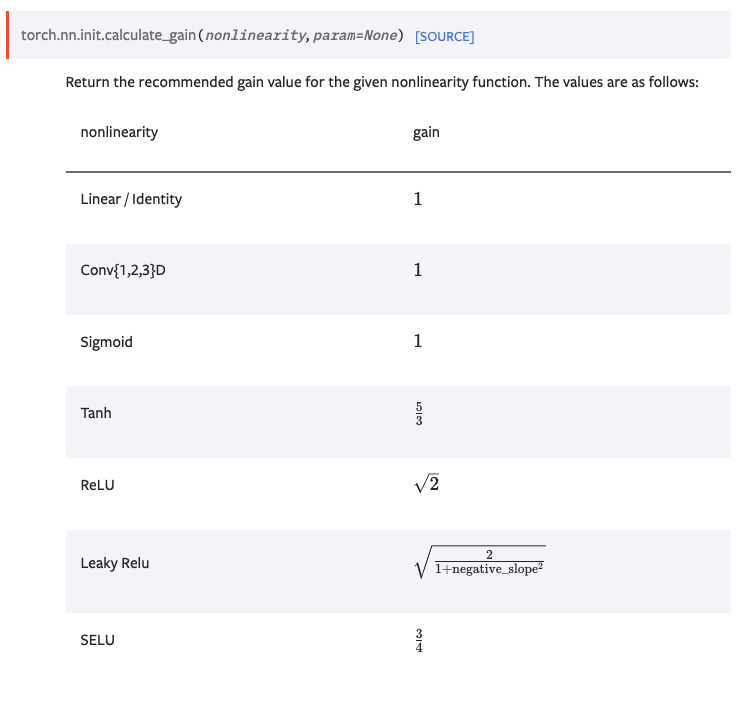


### Modern approaches

1. Normalisation layers: batch-norm, layer norm, group norm
2. Skip and residual connections
3. ...

## Activations

- Looking at the histogram of `h` (activation outputs from `torch.tanh`)
- `tanh` is a squashing function -> we see woo many values lie at the extrema of the span [-1, +1]

In [8]:
plt.hist(h.view(-1).data, 50);

NameError: name 'h' is not defined

In [ ]:
plt.hist(h_preact.view(-1).data, 50);

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(h_preact.abs() > 0.99, cmap="gray", interpolation="none");

plt.figure(figsize=(15, 5))
plt.imshow(h_preact.abs() / h_preact.max() > 0.99, cmap="gray", interpolation="none");  # must normalise

plt.figure(figsize=(15, 5))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="none");

## BatchNorm

- Controls distributions of activations

- Note: as they substract the mean, the added `bias` of the prededing layer is redundant
- BN layers have their own bias offset

## Model & Training

In [25]:
g = torch.Generator().manual_seed(876)

# Create an embedding tensor (latent embedding) for our characters
embedding_dim = 12
h_dim = 2**13
num_inputs = WINDOW * embedding_dim  # 'window' embeddings per sample + 'embedding_dim' values per embedding

C = torch.randn((num_classes, embedding_dim), generator=g)  # context - character embeddings
W1 = torch.randn((num_inputs, h_dim),         generator=g) * (5/3)/(h_dim * WINDOW)**0.5 # Shape: (num_inputs, num_neurons)
# b1 = torch.randn(h_dim,                       generator=g) * 0.005  # making non-zero helps introduce entropy
W2 = torch.randn((h_dim, num_classes),        generator=g) * 0.01  # Scale down the values to control logit magnitude
b2 = torch.randn(num_classes,                 generator=g) * 0  # We don't need to add more noise to the init logits

bnscale = torch.ones((1, h_dim))
bnshift = torch.zeros((1, h_dim))

bnmean_running = torch.zeros((1, h_dim))
bnstd_running = torch.ones((1, h_dim))

parameters = [C, W1, W2, b2, bnscale, bnshift]  # remove b1
print(f"Total parameters in model: {sum(p.nelement() for p in parameters)}")

for p in parameters:
  p.requires_grad = True
  
# To track stats
losses = []
batches = []

Total parameters in model: 737644


[     0] loss= 3.3662
[ 20000] loss= 4.0265
[ 40000] loss= 2.8695
[ 60000] loss= 2.4251
[ 80000] loss= 2.2919
[100000] loss= 2.5458
[120000] loss= 2.7012
[140000] loss= 2.1049
[160000] loss= 2.3523
[180000] loss= 2.2226
[200000] loss= 2.1730
[220000] loss= 2.5197
[240000] loss= 1.9316
[260000] loss= 2.0871
[280000] loss= 2.3780
[300000] loss= 1.9138
[320000] loss= 2.6598
[340000] loss= 2.2237
[360000] loss= 2.2499
[380000] loss= 2.4557
[400000] loss= 2.6828
[420000] loss= 2.3733
[440000] loss= 1.9652
[460000] loss= 1.9957
[480000] loss= 2.3818
[500000] loss= 2.4777


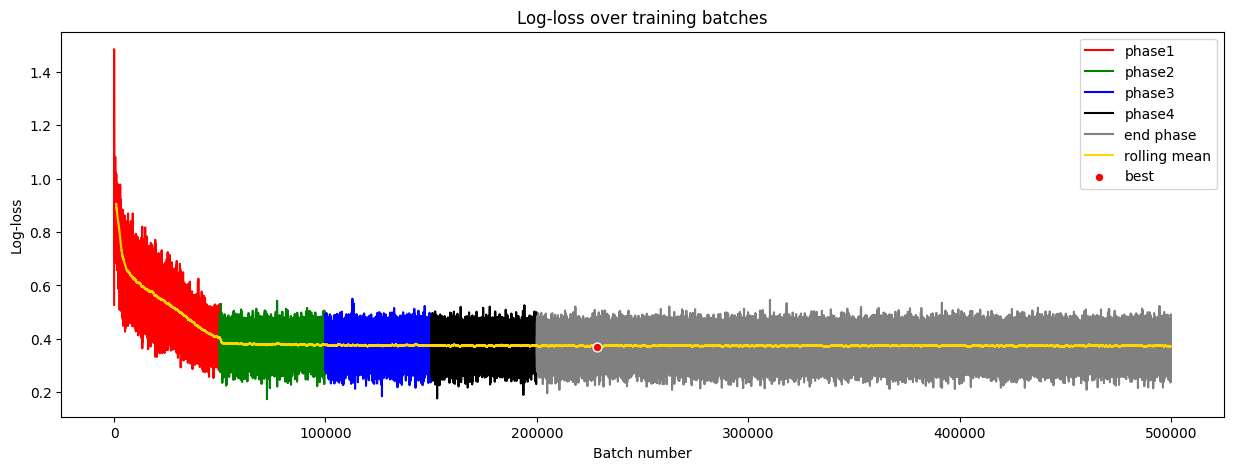

In [26]:
phase1 = 50_000
phase2 = 100_000
phase3 = 150_000
phase4 = 200_000

# Minibatch gradient descent
b = len(batches)
n_steps = 500_000
for batch in range(b, b + n_steps):
  
  # Create a minibatch
  ix = torch.randint(0, Xtr.shape[0], size=(32,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  emb = C[Xb]  # index into the embedding tensor at the position of the (batch) training indices

  # Compute the hidden layer transformation and apply non-linearity
  embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
  _h = embcat @ W1 #+ b1  # before batch norm
  
  # Apply batch norm before applying non-linearity -> use epsilon to prevent possible NaNs
  bnmeani = _h.mean(0, keepdim=True)
  bnstdi = _h.std(0, keepdim=True)
  h_preact = bnscale * ((_h - bnmeani) / (bnstdi + EPS)) + bnshift
  
  with torch.no_grad():
    # Keeping running values of the batch norms stats
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(h_preact)

  logits = h @ W2 + b2  # produces the output of our final layer (no softmax needed)
  loss = F.cross_entropy(logits, Yb)
  
  # Backward pass
  for p in parameters:
    p.grad = None  # Sets gradients to zero before backprop
  loss.backward()

  # Parameter update
  n = len(batches)
  if n < phase1:
    lr = 0.1
  elif n < phase2:
    lr = 0.01
  elif n < phase3:
    lr = 0.005
  elif n < phase4:
    lr = 0.001
  else:
    lr = 0.0001

  for p in parameters:
    p.data += -lr * p.grad

  if batch % 20000 == 0:
    print(f"[{batch:>6}] {loss=:>7.4f}")

  batches.append(batch)
  losses.append(loss.log10().item())

print(f"[{len(batches):>6}] {loss=:>7.4f}")

# Plotting code
plt.figure(figsize=(15, 5))
plt.plot(batches[:phase1], losses[:phase1], c="r", label="phase1")
plt.plot(batches[phase1:phase2], losses[phase1:phase2], c="g", label="phase2")
plt.plot(batches[phase2:phase3], losses[phase2:phase3], c="b", label="phase3")
plt.plot(batches[phase3:phase4], losses[phase3:phase4], c="k", label="phase4")

if len(batches) > phase4:
  plt.plot(batches[phase4:], losses[phase4:], c="gray", label="end phase")

rolling_mean = pd.DataFrame(losses, columns=["losses"]).rolling(1000).mean()
plt.plot(batches, rolling_mean.values, c="gold", label="rolling mean")

min_loss_x, min_loss_y = torch.min(torch.tensor(rolling_mean.dropna().values), 0)
plt.scatter(min_loss_y.data.item(), min_loss_x.item(), label="best", c="r", edgecolor="w", s=40, zorder=2)

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Log-loss")
plt.title("Log-loss over training batches");

Running the model for a long time with emb_dim=12 and h_dim=2^13 gives the following:

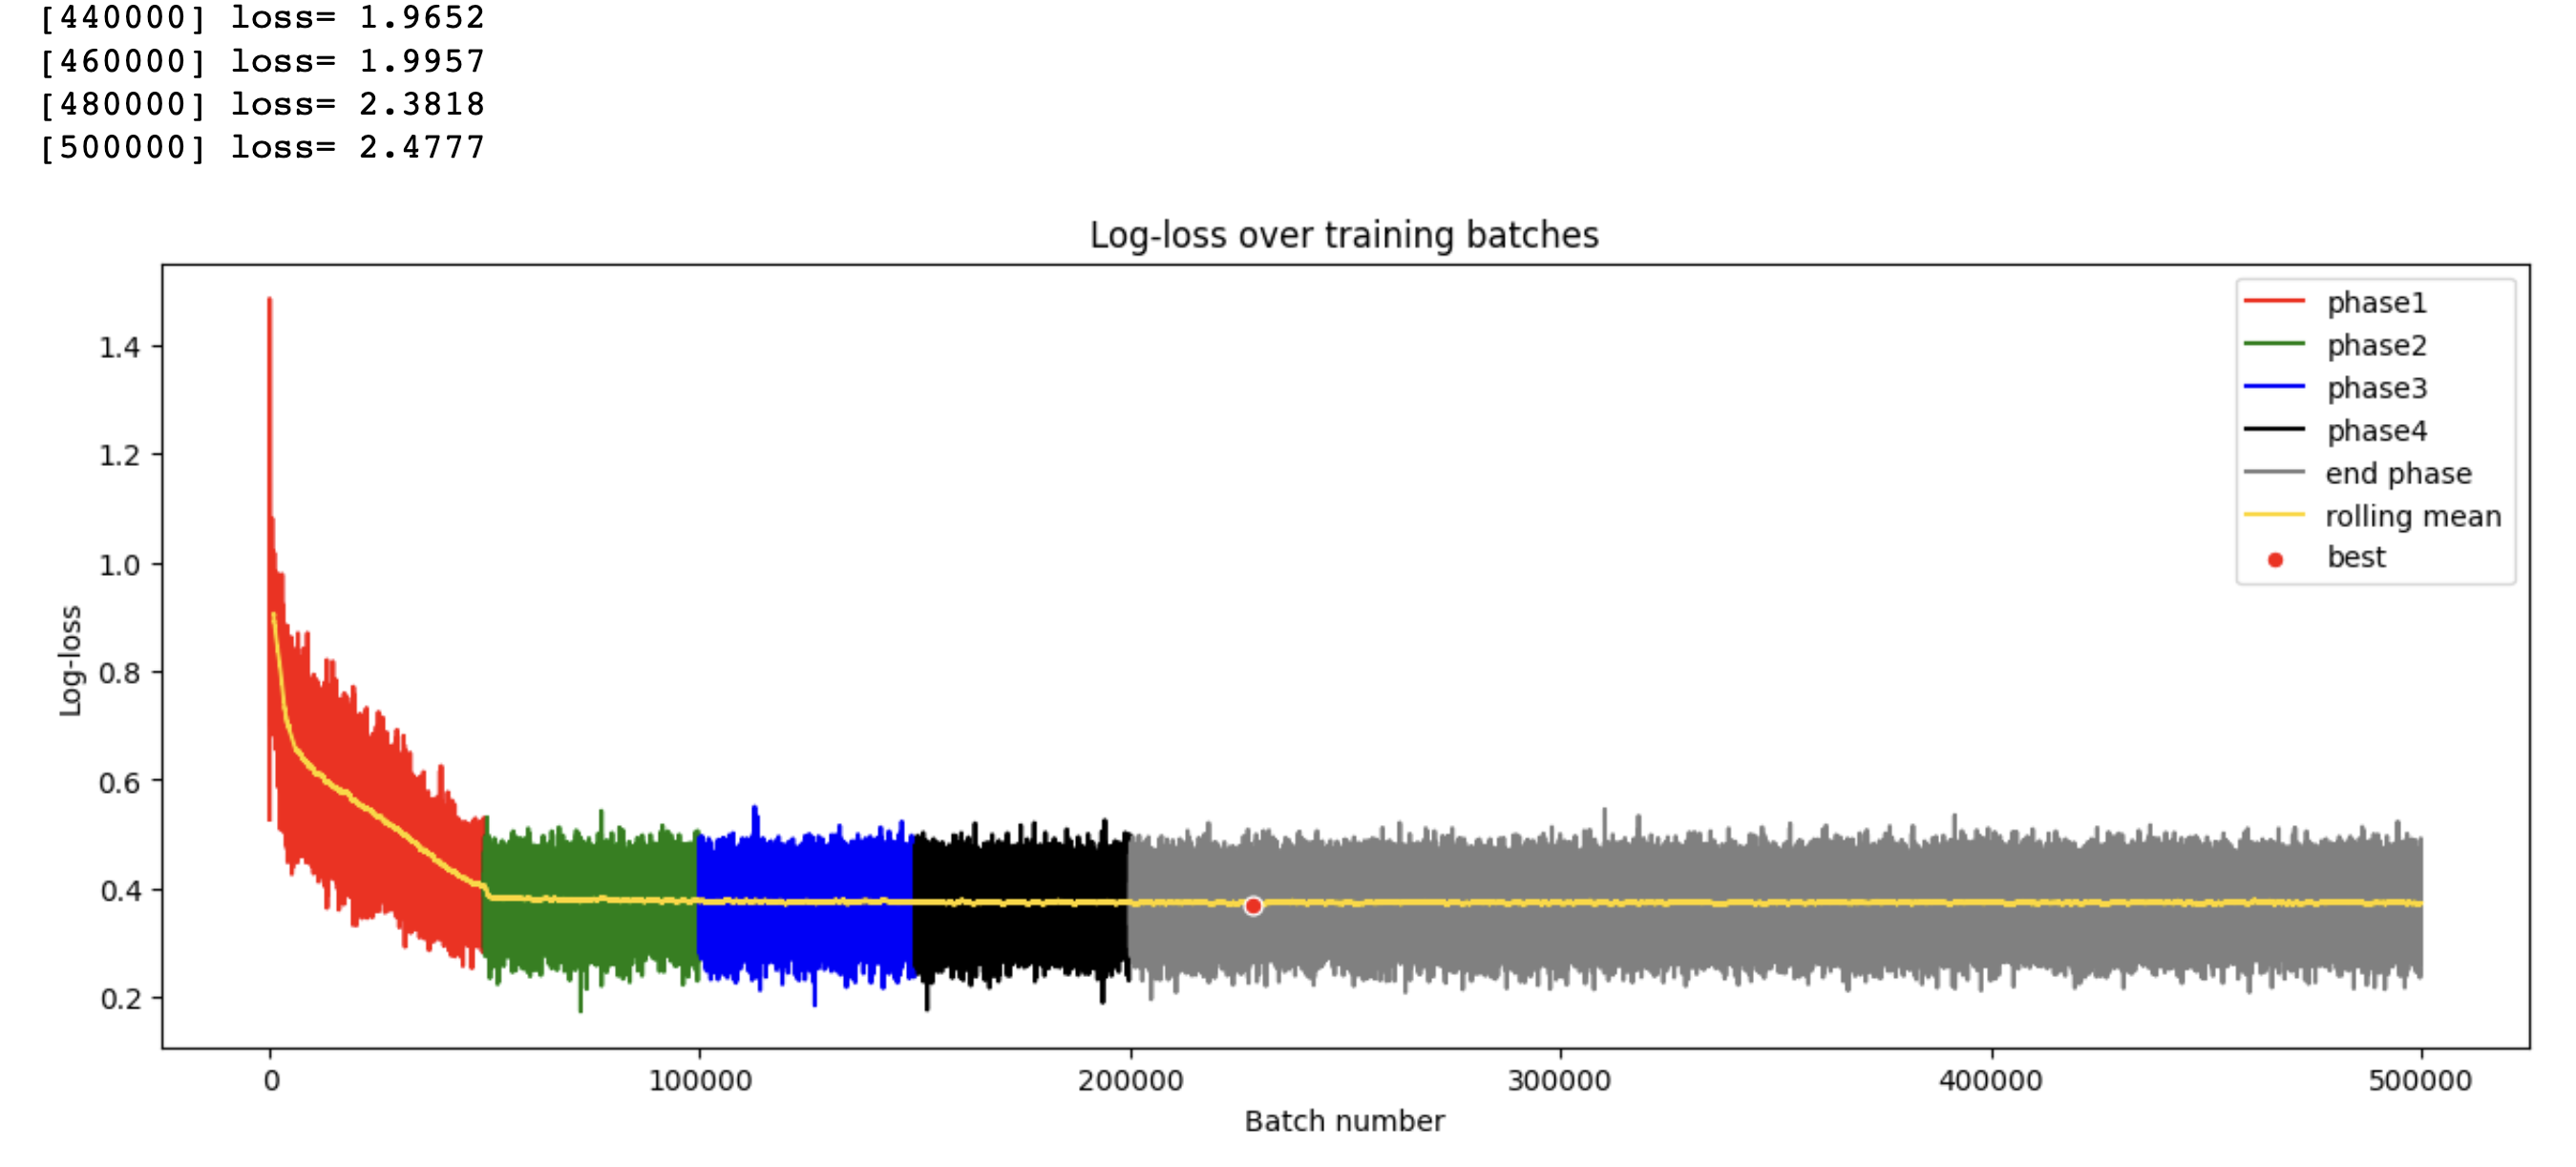

In [ ]:
b1.grad.max()  # If used, before a batch norm layer, we see this is basically zero!

In [27]:
# Compute training stats for batch norm
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  _h = embcat @ W1 #+ b1
  
  # Compute the statistics that we would normally compute over a single batch 
  bnmean = _h.mean(0, keepdim=True)
  bnstd = _h.std(0, keepdim=True)

print(bnmean[:, :20])
print(bnstd[:, :20])

tensor([[ 0.1174,  0.0434, -0.1154,  0.1280, -0.0094,  0.0050,  0.2237,  0.0091,
          0.0228, -0.0520,  0.0258,  0.0421,  0.0034,  0.1458,  0.1348,  0.1852,
         -0.3030, -0.0923, -0.1233,  0.0421]])
tensor([[0.9744, 0.9232, 1.0670, 0.9903, 1.0256, 0.9950, 0.9961, 0.9163, 1.0127,
         0.9031, 1.0053, 1.0340, 0.9130, 0.8784, 0.9308, 1.0009, 0.9283, 1.1132,
         0.9311, 1.0541]])


In [28]:
# After training fully, mean/std both converge towards the full training dataset's values
print(bnmean_running[:, :20])
print(bnstd_running[:, :20])

tensor([[ 0.1128,  0.0447, -0.1117,  0.1287, -0.0129,  0.0020,  0.2258,  0.0082,
          0.0143, -0.0561,  0.0278,  0.0436,  0.0021,  0.1390,  0.1351,  0.1897,
         -0.3071, -0.0932, -0.1250,  0.0421]])
tensor([[0.8750, 0.8612, 0.9958, 0.8800, 0.9172, 0.9247, 0.9023, 0.8291, 0.9155,
         0.8006, 0.9370, 0.9531, 0.8400, 0.8191, 0.8231, 0.9173, 0.8418, 1.0134,
         0.8532, 0.9920]])


In [29]:
@torch.no_grad()
def split_loss(split: str) -> None:
  """compute and print the loss for the named split of the dataset: {train, val, test}."""
  x, y = {
    "train": (Xtr, Ytr),
    "val":   (Xdev, Ydev),
    "test":  (Xte, Yte),
  }[split]
  
  emb = C[x]  # index into the embedding tensor at the position of the training indices

  # Compute the hidden layer transformation and apply non-linearity
  embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
  _h = embcat @ W1 #+ b1  # before batch norm
  
  # Apply batch norm before applying non-linearity
  h_preact = bnscale * (_h - bnmean_running) / (bnstd_running + EPS) + bnshift
  
  h = torch.tanh(h_preact)
  logits = h @ W2 + b2  # computes the output of our final hidden layer
  loss = F.cross_entropy(input=logits, target=y)  # Compute the loss (posed as binary classification)
  print(f"Full loss {split:<6} {loss:>8.6f}")
  
split_loss("train")
split_loss("val")
split_loss("test")

Full loss train  2.356256
Full loss val    2.383876
Full loss test   2.369135


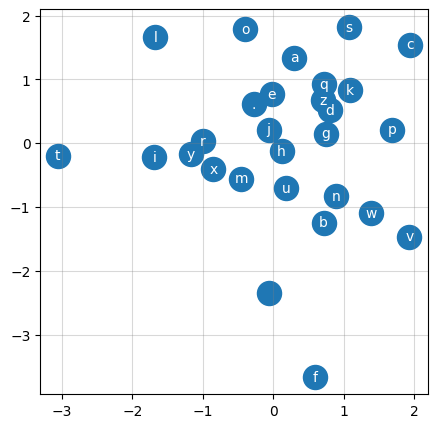

In [30]:
plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=300)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), s=itos[i], ha="center", va="center", color="white", size=10)

plt.grid(color="gray", alpha=0.3)

### Inference

In [31]:
for i in range(20): 
    
  ix = stoi[start_end_char]
  context = [ix] * WINDOW
  new_word = []

  while True:
    emb = C[torch.tensor([context])]  # shape (1, window, embedding)  (1, 5, 2)

    # Compute the hidden layer transformation and apply non-linearity
    embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
    _h = embcat @ W1 #+ b1  # before batch norm
    # Apply batch norm before applying non-linearity
    h_preact = bnscale * (_h - bnmean_running) / (bnstd_running + EPS) + bnshift

    h = torch.tanh(h_preact)
    logits = h @ W2 + b2  # computes the output of our final hidden layer

    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    ch = itos[ix]
    if ch == start_end_char:
      break
    new_word.append(ch)
    context = context[1:] + [ix]

  gen_city = ''.join(new_word)
  print(f"[Word {i:>2}]: {gen_city:<20} -- in dataset: {(gen_city + start_end_char) in cities}")

[Word  0]: souvria              -- in dataset: False
[Word  1]: neveliferuth         -- in dataset: False
[Word  2]: an rani              -- in dataset: False
[Word  3]: calajofo             -- in dataset: False
[Word  4]: santon               -- in dataset: False
[Word  5]: sweld                -- in dataset: False
[Word  6]: doish                -- in dataset: False
[Word  7]: bracernovereye       -- in dataset: False
[Word  8]: morol                -- in dataset: False
[Word  9]: shineho              -- in dataset: False
[Word 10]: majofoxo             -- in dataset: False
[Word 11]: main barn            -- in dataset: False
[Word 12]: pommadn              -- in dataset: False
[Word 13]: wondromide           -- in dataset: False
[Word 14]: san badno            -- in dataset: False
[Word 15]: ento                 -- in dataset: False
[Word 16]: woodoldana           -- in dataset: False
[Word 17]: lee sandouriena      -- in dataset: False
[Word 18]: nandamallu           -- in dataset:

## Implementing some modules

In [1]:
import torch

In [19]:
class Linear:
  """Fully connected linear layer, without an activation."""
  
  def __init__(self, fan_in: int, fan_out: int, bias=True) -> None:
    """Initialise the weights of the layer"""    
    self.weight = torch.randn((fan_in, fan_out), dtype=torch.float32) / fan_in**0.5 # K.He normalisation
    self.bias = torch.zeros(fan_out) if bias else None
    
  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    """Perform `y = x @ w + b`."""
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out
  
  def parameters(self) -> list[torch.Tensor]:
    """Provide a list of the (tensor) parameters held within this module."""
    return [self.weight] + ([] if self.bias is None else [self.bias])


# inp = torch.randn((20, 20))
# f_in = inp.shape[0] * inp.shape[1]
# linear = Linear(f_in, fan_out=10, bias=True)

# f = inp.flatten()
# assert f.shape == (f_in,)

# out = linear(f)
# inp.shape, f.shape, out.shape, linear.parameters()

In [24]:
class BatchNorm1d:
  """Batch normalisation for 1D input tensors, as per Ioffe & Szegedy.
  
  BatchNorm1 normalises a batch across the *features* of a batch. for example:
  x = [[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9],
       [7, 5, 3, 1, 0]]     shape: (3, 5) -> (batch_size, num_features)
       
  We normalise across feature_i over the batch, so for feature 0, we have: f_0 = x[:, 0]
    - f_0_mean = (0 + 5 + 7)/3
    - f_0_var = 1/3 * sum((f_0 - f_0_mean)**2)
    
  Then the normalisations step:
  
  f_0_norm = (f_0 - f_0_mean) * (f_0_var + eps)**-0.5
  
  Finally the gain (gamma) and bias (beta) parameters are brought in:
  
  f_0_out = gamma * f_0_norm + beta
  
  This is performed over all features. We also keep an exponentially weighted moving average of the mean and var.
  During inference, we do not update those numbers, but do use them instead of the inference batch's own stats.
  """
  
  def __init__(self, num_features: int, eps: float = 1e-6, momentum: float = 0.1) -> None:
    """Initialise all variables including - NOTE: this layer is stateful."""
    self.eps = eps
    self.momentum = momentum
    self.training = True  # we must know in which state we are in; different behaviour in train vs inference mode
    
    # These are updated during the forward pass only, do not have gradients.
    self.running_mean = torch.zeros(num_features)
    self.running_var = torch.ones(num_features)
    # These are updated during training, forward & backward pass
    self.gamma = torch.ones(num_features)
    self.beta = torch.zeros(num_features)    
    
  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    """Perform batch normalisation as per """

    if self.training:
      # Compute batch stats across the features
      # This is where we mingle statistics across samples in the batch! Not good!
      bmean = x.mean(dim=0, keepdim=True)
      bvar = x.var(dim=0, keepdim=True)

    else:
      bmean = self.running_mean
      bvar = self.running_var

    xhat = (x - bmean) / torch.sqrt(bvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = ((1 - self.momentum) * self.running_mean) + self.momentum * bmean
        self.running_var = ((1 - self.momentum) * self.running_var) + self.momentum * bvar

    return self.out
  
  def parameters(self) -> list[torch.Tensor]:
    """Return a list of all parameters of this layer."""
    return [self.gamma, self.beta]
  
# # Test out the layer
d = 5
batch = torch.arange(10, dtype=torch.float32).view(2, -1)
print(f"{batch.shape=}\n{batch=}")

bn = BatchNorm1d(num_features=d)
bnbatch = bn(batch)

# bn.running_mean
# # After forward pass, gamma and beta remain unchanged
assert torch.all(bn.gamma == 1.0)
assert torch.all(bn.beta == 0.0)

batch.shape=torch.Size([2, 5])
batch=tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])


In [8]:
class Tanh:
  """Implement the element-wise tanh operation manually as a module."""
  
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = torch.tanh(x)
    #exp_2x = torch.exp(2*x)
    #self.out = (exp_2x -1) * (exp_2x + 1)**-1
    return self.out
  
  def parameters(self):
    return []

# tanh = Tanh()
# batch = torch.tensor(range(5), dtype=torch.float32, requires_grad=True).log()
# out = tanh(batch)
# print(f"{out.shape=}\n{out=}")
# assert torch.equal(out, torch.tanh(batch)), "BUZZER"

In [9]:
torch.manual_seed(42);

In [27]:
n_embed = 10
n_hidden = 200
vocab_size = 28
C = torch.randn((vocab_size, n_embed))
layers = [
  Linear(n_embed * 3, n_hidden, bias=False),
  BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1  # make the last layer start with low confidence on predictions
  
parameters = [C] + [param for layer in layers for param in layer.parameters()]
print(f"Total num parameters: {sum(param.nelement() for param in parameters)}")

for p in parameters:
  p.requires_grad = True

Total num parameters: 12308


In [144]:
len(parameters)

5

## Visualisation #1